In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pets-facial-expression-dataset/Other/aug-88-54.jpg
/kaggle/input/pets-facial-expression-dataset/Other/45.jpg
/kaggle/input/pets-facial-expression-dataset/Other/56.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-141-02.jpg
/kaggle/input/pets-facial-expression-dataset/Other/20.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-37-49.jpg
/kaggle/input/pets-facial-expression-dataset/Other/58.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-168-37.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-80-43.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-183-55.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-114-30.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-152-19.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-180-52.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-195-12.jpg
/kaggle/input/pets-facial-expression-dataset/Other/aug-123-39.jpg
/kaggle/input/pets-facial-expression-dataset/

In [3]:
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

2024-03-22 16:06:51.050362: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 16:06:51.050460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 16:06:51.199448: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Install the transformers library from HuggingFace
!pip install transformers torch pytesseract

# You'll also need some extra tools that some of these models use under the hood
! pip install sentencepiece sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 11.8 MB/s eta 0:00:0000:010:01


# Load Data

In [5]:
classes = {'Other':0, 'Sad':1, 'happy':2,'Angry':3}
imgs = []
#labels = []
data_path = '/kaggle/input/pets-facial-expression-dataset/Master Folder/train'
for (cl, i) in classes.items():
    images_path = [elt for elt in os.listdir(os.path.join(data_path, cl)) if elt.find('.jpg')>0]
    for img in tqdm(images_path[:300]):
        path = os.path.join(data_path, cl, img)
        if os.path.exists(path):
            image = Image.open(path)
            image = image.resize((256, 256))
            imgs.append(image)
            #labels.append(i)

100%|██████████| 250/250 [00:02<00:00, 106.29it/s]


In [6]:
n = 7
def random_images(size):
    if n < len(imgs):
        # get a random index between (0) and (len imgs - n)
        rand_index = np.random.randint(0, len(imgs)-size)

        # we get next n indexes starting from the random index
        random_range = np.arange(rand_index, rand_index+size)

        return random_range

# random range of indexes
rand_range_index = random_images(n)

# first index of range
low = rand_range_index[0]

# last index
high = rand_range_index[len(rand_range_index)-1]

In [7]:
imgs_sample = imgs[low:high+1]

# Model

In [8]:
### From huggingface
### Model ID: openai/clip-vit-base-patch32

In [9]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

#url = "https://images.pexels.com/photos/170811/pexels-photo-170811.jpeg?cs=srgb&dl=road-car-vehicle-170811.jpg&fm=jpg"
#image = Image.open(requests.get(url, stream=True).raw)

animal_species_desc = ['a photo of a cat', 'a photo of a dog', 'a photo of a bird', 'a photo of a rabbit', 'a photo of a hamster', 
                      'a photo of a sheep', 'a photo of a horse', 'a photo of a cow']
# each text description refers to a class
inputs = processor(text=animal_species_desc, images=imgs_sample, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [10]:
# we need this conversion for the dataframe
np_probs = probs.detach().numpy()
np_probs

array([[3.9834209e-04, 4.3756663e-04, 1.2705092e-04, 9.8087710e-01,
        1.7990628e-02, 6.8635250e-05, 5.9068960e-05, 4.1671807e-05],
       [9.8111928e-01, 6.7372452e-03, 1.8866434e-03, 2.6358331e-03,
        2.6137552e-03, 4.0301951e-04, 2.6138849e-03, 1.9902501e-03],
       [9.8682421e-01, 3.8557232e-03, 2.8356668e-03, 1.9137813e-03,
        2.4255147e-04, 1.4554553e-04, 1.3682657e-03, 2.8142382e-03],
       [4.8176106e-03, 9.5637369e-01, 1.3291723e-03, 8.4882136e-03,
        5.7308259e-04, 6.5233260e-03, 5.3260727e-03, 1.6568825e-02],
       [9.9352384e-01, 1.4656810e-03, 4.3095258e-04, 3.3929904e-03,
        6.1752537e-04, 1.7438116e-04, 1.9880074e-04, 1.9583626e-04],
       [9.9120742e-01, 2.5324125e-03, 6.1602925e-04, 3.3394136e-03,
        2.5166656e-04, 4.5524799e-04, 8.3487650e-04, 7.6298317e-04],
       [5.7750982e-05, 5.6554662e-04, 4.0688337e-05, 9.7368989e-05,
        2.7847548e-06, 9.6546245e-01, 1.1457547e-03, 3.2627519e-02]],
      dtype=float32)

In [11]:
# classes are:
# cat
# dog
# bird
# rabbit
# hamster
# sheep
# horse
#Fish
#Cow
#Deer
#Mouse
#Elephant
#Bear
#Lion
#Tiger
#Monkey
#Snake
#Wolf
#Fox
#Pig
#Goat
#Chicken


'''df_ = pd.DataFrame({'cat':np_probs[:,0],
                    'dog':np_probs[:,1],
                    'bird':np_probs[:,2],
                    'rabbit': np_probs[:,3],
                    'hamster': np_probs[:,4], 
                    'sheep': np_probs[:,5],
                    'horse': np_probs[:,6],
                   })
df_'''

"df_ = pd.DataFrame({'cat':np_probs[:,0],\n                    'dog':np_probs[:,1],\n                    'bird':np_probs[:,2],\n                    'rabbit': np_probs[:,3],\n                    'hamster': np_probs[:,4], \n                    'sheep': np_probs[:,5],\n                    'horse': np_probs[:,6],\n                   })\ndf_"

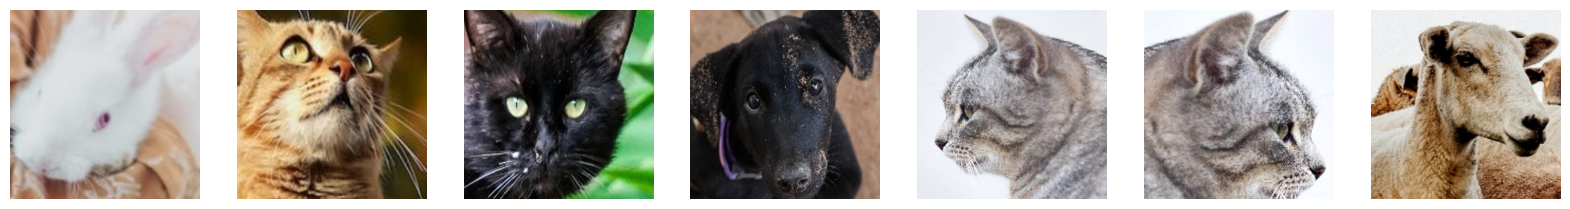

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
for i in range(n):
    plt.subplot(1,n,i+1)
    plt.axis('off')
    plt.imshow(imgs_sample[i])

In [13]:
animal_species = ['cat', 'dog', 'bird', 'rabbit', 'hamster', 'sheep', 'horse','cow']
df_ = pd.DataFrame({animal: np_probs[:, i] for i, animal in enumerate(animal_species)})
df_

,cat,dog,bird,rabbit,hamster,sheep,horse,cow
0,0.000398,0.000438,0.000127,0.980877,0.017991,0.000069,0.000059,0.000042
1,0.981119,0.006737,0.001887,0.002636,0.002614,0.000403,0.002614,0.001990
2,0.986824,0.003856,0.002836,0.001914,0.000243,0.000146,0.001368,0.002814
3,0.004818,0.956374,0.001329,0.008488,0.000573,0.006523,0.005326,0.016569
4,0.993524,0.001466,0.000431,0.003393,0.000618,0.000174,0.000199,0.000196
5,0.991207,0.002532,0.000616,0.003339,0.000252,0.000455,0.000835,0.000763
6,0.000058,0.000566,0.000041,0.000097,0.000003,0.965462,0.001146,0.032628
